In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Conversions. 1:
FEET_TO_METERS = 0.3048
SQFEET_TO_SQMETERS = 0.092903
CFS_TO_CMS = 0.028316847
SQMI_TO_SQKM = 2.589988110336
FPS_TO_MPS = 0.3048000

In [9]:
# USGS HYDRoacoustic dataset in support of the Surface Water Oceanographic Topography satellite mission (HYDRoSWOT)
# https://www.sciencebase.gov/catalog/item/57435ae5e4b07e28b660af55
swot_adcp = gpd.read_file('../data/SWOT_ADCP_Dataset_4326.gpkg')

In [10]:
swot_adcp.columns

Index(['host', 'agency_cd', 'site_no', 'station_nm', 'dec_lat_va',
       'dec_long_va', 'coord_datum_cd', 'drain_area_va',
       'contrib_drain_area_va', 'alt_va', 'alt_datum_cd', 'site_tp_cd',
       'ad_site_cd', 'site_visit_start_dt', 'site_visit_start_dt_sg',
       'data_aging_cd', 'q_meas_no', 'q_meas_dt', 'q_meas_td', 'q_va',
       'stage_va', 'stage_diff_va', 'stage_diff_du', 'mean_idx_vel_va',
       'std_sec_area_va', 'std_sec_vel_va', 'q_adj_va', 'base_flw_cd',
       'q_meas_qual_cd', 'q_meas_used_fg', 'q_meas_chan_nu', 'stream_wdth_va',
       'xsec_area_va', 'mean_vel_va', 'max_vel_va', 'q_coef_var_va',
       'flw_meas_fc', 'mean_depth_va', 'max_depth_va', 'adcp_freq_cd',
       'q_meas_type_cd', 'q_meth_cd', 'vel_meth_cd', 'meas_q_va',
       'chan_stability_cd', 'chan_mat_cd', 'vel_dstrb_cd', 'vert_vel_dstrb_cd',
       'q1_Percent_va', 'q1_Outside5Percent', 'q2_xsec_area_X_mean_vel_va',
       'q2_Percent_q_va', 'q2_q_va_OutsideBounds', 'q2_Percent_meas_q_va',
    

In [12]:
from functools import partial

def scalar_mutate(df, tranformation_map):
    def scale(col, val, x):
        return x[col] * val
    
    cols_to_subset = list(tranformation_map.keys())
    
    df_subset = df[cols_to_subset]
    
    scalar_tranformation_map = {k: partial(scale, k, v) for (k,v) in tranformation_map.items() if v}
    
    ## for some reason this does not work
    # scalar_tranformation_map = {k: lambda x: x[k] * v for (k,v) in tranformation_map.items()}
    return df_subset.assign(**scalar_tranformation_map)

cols_of_interest = {
    "site_no": None,
    "drain_area_va": SQMI_TO_SQKM, 
    "contrib_drain_area_va": SQMI_TO_SQKM,
    "alt_va": FEET_TO_METERS,
    "stage_va": FEET_TO_METERS,
    "stream_wdth_va": FEET_TO_METERS,
    "xsec_area_va": SQFEET_TO_SQMETERS,
    "mean_depth_va": FEET_TO_METERS,
    "max_depth_va": FEET_TO_METERS
}

In [13]:
df = scalar_mutate(swot_adcp, cols_of_interest)

<AxesSubplot:xlabel='stream_wdth_va', ylabel='Count'>

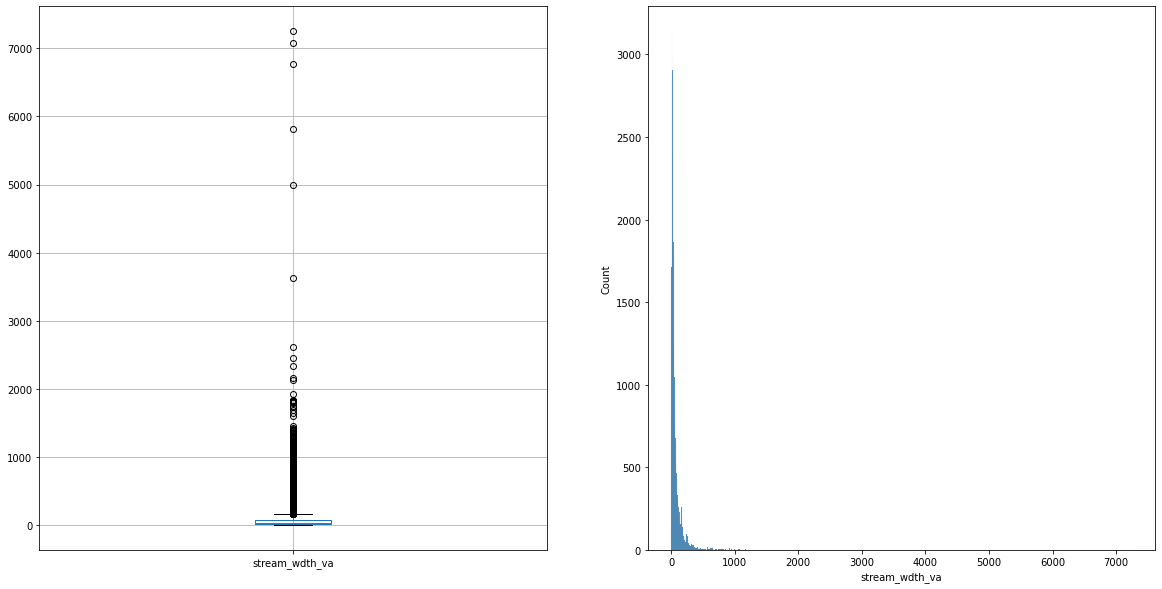

In [23]:
f, axes = plt.subplots(1,2, figsize=(20,10))

df.boxplot(column="stream_wdth_va", ax=axes.flat[0])
sns.histplot(data=df, x="stream_wdth_va", ax=axes.flat[1])

In [16]:
def trapeziod_b(area, height, B):
    return 2 * (area / height) - B

In [59]:
(df['max_depth_va'] + df['mean_depth_va'])/2

1.0000769851441293

In [60]:
df = df.assign(b=trapeziod_b(df['xsec_area_va'], df['max_depth_va'], df['stream_wdth_va']))
df_mean_depth = df.assign(b=trapeziod_b(df['xsec_area_va'], df['mean_depth_va'], df['stream_wdth_va']))

# channel height is very sensitive when calculating b
df_mean_max_and_mean = df.assign(b=trapeziod_b(df['xsec_area_va'],
                                               ((df['max_depth_va'] + df['mean_depth_va']) / 2),
                                               df['stream_wdth_va']))

In [61]:
df = df.assign(b_percent_of_B=df['b']/df['stream_wdth_va'])
df_mean_depth = df_mean_depth.assign(b_percent_of_B=df_mean_depth['b']/df_mean_depth['stream_wdth_va'])


df_mean_max_and_mean = df_mean_max_and_mean.assign(b_percent_of_B=df_mean_max_and_mean['b']/df_mean_max_and_mean['stream_wdth_va'])

In [62]:
print(df.loc[0, 'b'])
print(df_mean_depth.loc[0, 'b'])
print(df_mean_max_and_mean.loc[0, 'b'])

40.704020635881136
101.3328063502345
65.68649910378619


In [64]:
print("mean percent b of B:")
print(f"df: {(df['b_percent_of_B'].replace([np.inf, -np.inf], np.nan) * 100).mean()}")
print(f"df_mean_depth: {(df_mean_depth['b_percent_of_B'].replace([np.inf, -np.inf], np.nan) * 100).mean()}")
print(f"df_mean_max_and_mean: {(df_mean_max_and_mean['b_percent_of_B'].replace([np.inf, -np.inf], np.nan) * 100).mean()}")

mean percent b of B:
df: 33.33259660814816
df_mean_depth: 93.23829896311939
df_mean_max_and_mean: 56.2429644032433
